In [1]:
#!pip install keras
#!pip install -U scikit-learn
#!pip install pillow
#!pip install matplotlib
#!pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

2023-04-05 17:12:15.841762: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 17:12:15.872344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
"""
Notes for tmrw

u reduced batch size to 16 and u saw some improvements still plateuing
now ur pissed off coz accuracy is not increasing even though u put 0 data augmentation
tmrw I have to look into that"""

'\nNotes for tmrw\n\nu reduced batch size to 16 and u saw some improvements still plateuing\nnow ur pissed off coz accuracy is not increasing even though u put 0 data augmentation\ntmrw I have to look into that'

## Variables Being Used

In [4]:
#variables being used
batch_size=32
#val_split=0.2 #20 percent validation
image_size=256 
image_shape=(image_size,image_size)
#file_directory='/root/DR no aug'
#file_directory='/root/01DR_noDR'
train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training'
validation_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Validation'
alt_train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training_no_weights'

In [5]:
!nvidia-smi

Wed Apr  5 17:12:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   37C    P8    35W / 350W |  11231MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Datasets

In [6]:

from keras.applications.mobilenet import preprocess_input #for that vgg16
#import tensorflow as tf

#from keras.applications.Xception import preprocess_input

training_datagen = ImageDataGenerator( 
        preprocessing_function=preprocess_input, # use this only when using VGG16
        #rescale=1./255,
        rotation_range=15,#can change this
        shear_range=0.1,#can change this
        zoom_range=0.1, #can change this
        horizontal_flip=True,
        fill_mode='reflect',# constant,reflect,wrap,
        )

validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./255    
        )

#Creating our generators, no need of changing values here
train_generator = training_datagen.flow_from_directory( #Creating our training generator 
        train_file_directory,  
        target_size=image_shape,
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
        )

validation_generator = validation_datagen.flow_from_directory( #Creating our validation generator
        validation_file_directory, 
        target_size=image_shape, 
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
)

Found 561 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


## Displaying Images

In [7]:
# Enable/Disable to see 4 random images
"""fig, axs=plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
  axs[i].imshow(train_generator[i][0][0], cmap='gray', vmin=0, vmax=1)
#axs[0].plt.show()"""

"fig, axs=plt.subplots(ncols=4, figsize=(20,20))\nfor i in range(4):\n  axs[i].imshow(train_generator[i][0][0], cmap='gray', vmin=0, vmax=1)\n#axs[0].plt.show()"

## Creating weights

In [8]:
import numpy as np ## Calculating the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weighing = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights=dict(zip(np.unique(train_generator.classes), class_weighing))

print(class_weights)

{0: 0.6051779935275081, 1: 0.9739583333333334, 2: 3.1166666666666667}


## Creating Model

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.optimizers import SGD
import keras

In [10]:
base_model = keras.applications.MobileNet(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

#base_model.trainable = False
inputs = keras.Input(shape=(image_size, image_size, 3))

#for layer in base_model.layers[:15]:
#   layer.trainable = False
#for layer in base_model.layers[15:]:
#   layer.trainable = True

x = base_model(inputs)

x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.15)(x)  # Regularize with dropout
#x=keras.layers.Dense(100)(x)
#x=keras.layers.Dense(50)(x)
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.summary(expand_nested=True)

2023-04-05 17:12:17.743165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-05 17:12:17.750147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-05 17:12:17.750373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 256, 256, 3)]     0         |
|                                                               |
| conv1 (Conv2D)            (None, 128, 128, 32)      864       |
|                                                               |
| conv1_bn (BatchNormalizatio  (None, 128, 128, 32)   128       |
| n)                                                            |
|                                                               |
| conv1_relu (ReLU)         (None, 128, 128, 32)      0      

### Compile

In [11]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), #SGD or adam
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

### Generating Callbacks

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="/root/DR-detection-using-OCT-A/saved_models/MobileNet_{val_accuracy:.2f}_{epoch:02d}.hdf5"

checkpoint= ModelCheckpoint(filepath,monitor='val_accuracy',verbose=0,save_best_only=True,mode='max')
early_stop=EarlyStopping(monitor='val_accuracy',patience=100,verbose=0) #only change patience

callback_list=[checkpoint]#add the callbacks used

### Model.Fit()

In [13]:
%%notify
history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//batch_size,
        verbose=1, 
        epochs=300,  #change this
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//batch_size,
        callbacks=callback_list,
        class_weight=class_weights
)
print("Done bro")

Epoch 1/300


2023-04-05 17:12:19.278641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-05 17:12:30.845461: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 64.00MiB (rounded to 67108864)requested by op model/mobilenet_1.00_224/conv1/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-05 17:12:30.845578: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-05 17:12:30.845608: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 75, Chunks in use: 73. 18.8KiB all

ResourceExhaustedError: Graph execution error:

Detected at node 'model/mobilenet_1.00_224/conv1/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_34081/2014009322.py", line 1, in <module>
      get_ipython().run_cell_magic('notify', '', 'history=model.fit(\n        train_generator,\n        steps_per_epoch=len(train_generator.classes)//batch_size,\n        verbose=1, \n        epochs=300,  #change this\n        validation_data=validation_generator,\n        validation_steps=len(validation_generator.classes)//batch_size,\n        callbacks=callback_list,\n        class_weight=class_weights\n)\nprint("Done bro")\n')
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2475, in run_cell_magic
      result = fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/jupyternotify/jupyternotify.py", line 62, in notify
      output = get_ipython().run_cell(cell)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_34081/1410449998.py", line 1, in <module>
      history=model.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/mobilenet_1.00_224/conv1/Conv2D'
OOM when allocating tensor with shape[32,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/mobilenet_1.00_224/conv1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5439]

<IPython.core.display.Javascript object>

### Curves

NameError: name 'history' is not defined

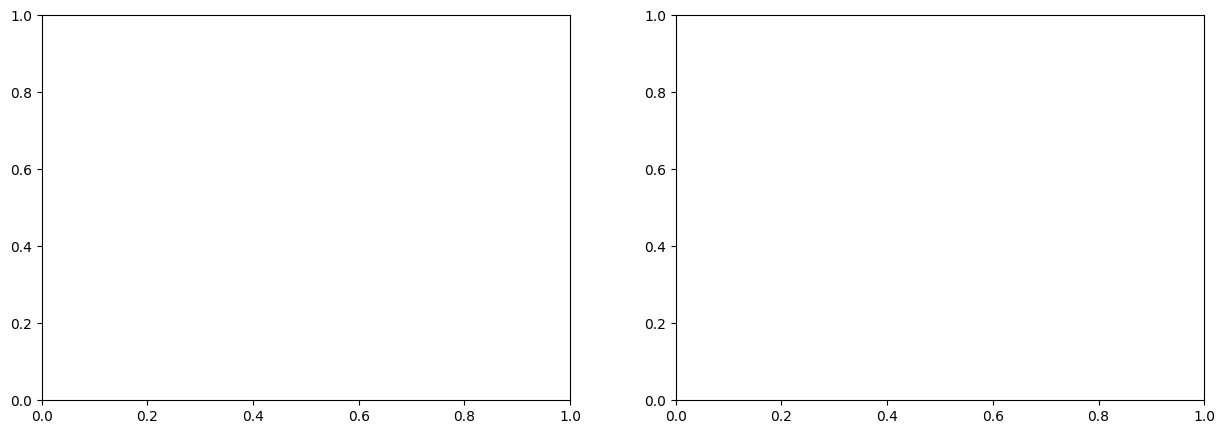

In [14]:
#loss curve
fig, axs=plt.subplots(ncols=2,figsize=(15, 5))#, figsize=(20,20))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set(title='Loss', xlabel='Epochs', ylabel='Epochs');

#accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
axs[1].plot(epochs, acc, 'y', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Epochs');

In [ ]:
"""prediction_classes = np.array([])
true_classes =  np.array([])
i=0
for x, y in validation_generator:
    if i==len(validation_generator.classes):
        break    
    i=i+1
    prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x,verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
print(classification_report(true_classes, prediction_classes))"""

In [ ]:
#model.save('to_continue.h5')
#continue_model=load_model('to_continue.h5')

## Evaluating Model

In [ ]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

#model = load_model('/root/44-0.82.hdf5')

In [ ]:
#new_model=load_model(".hdf5")

In [ ]:
data_eval=validation_generator
model_eval=model
results=model_eval.evaluate_generator(data_eval, steps=len(data_eval.classes)//batch_size)
print("Loss and accuracy are", results)
Y_pred = model_eval.predict_generator(data_eval, steps=len(data_eval.classes)//batch_size+1)
#print(train_generator.classes)
y_pred = np.argmax(Y_pred, axis=1)
#print(train_generator.classes)
#print(y_pred)
#print(X)
        
print('Confusion Matrix')
cm=confusion_matrix(data_eval.classes,y_pred)
target_names = ['NoDR', 'mildDR','seriousDR']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')

print(classification_report(data_eval.classes,y_pred, target_names=target_names))